# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List, Tuple
import string

import seaborn as sns

import os
import random

sns.set(palette='summer')
sns.set_style('darkgrid')


In [2]:
# фиксируем случайность, для удобства сравнения качества моделей
def seed_torch(seed=42):
    '''function for locking the random seed'''
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['PL_GLOBAL_SEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(mode=True)

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Found cached dataset ag_news (C:/Users/Nikita/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = ['<unk>', '<bos>', '<eos>', '<pad>']
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.append(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 2000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
seed_torch()
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

seed_torch()
eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

### Подготовка

In [10]:
def training_loop(model, train_dataloader, eval_dataloader, num_epoch: int = 5):
    '''Basic train loop suitable for multiple models'''
    
    eval_steps = len(train_dataloader) // 2

    losses = []
    acc = []

    seed_torch()
    model = model
    seed_torch()
    criterion = nn.CrossEntropyLoss()
    seed_torch()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader=eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    return losses, acc


In [11]:
def plotting_results(losses: Tuple, accuracies: Tuple):
    '''Basic plotting function for accuracies and losses'''
    
    for (name, values), color in zip(losses.items(), ['red', 'blue']):
        plt.plot(np.arange(len(losses[name])), losses[name], color=color, label=name)
    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    for (name, values), color in zip(losses.items(), ['red', 'blue']):
        plt.plot(np.arange(len(accuracies[name][1:])), accuracies[name][1:], color=color, label=name)
        print(f"Лучшая accuracy для подхода {name}: {max(accuracies[name]):.3f}")
    plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

### Задание 1
Для более обьективного сравнения моделей случайность была зафиксирована (ф-ия seed_torch).

Для применения модели из семинара необходимо в классе CharLM, в методе __init__ поменять значение параметра num_classes, использующегося в последнем слое полносвязной сети, с 2 на 4.
Лучшая точность достигнута при агрегации mean (accuracy=90.75), точность модели при исппользовании агрегации max равна 90.60.

In [12]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 2, aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [13]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    seed_torch()
    print(f'Starting for {aggregation_type}')
    model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type, num_classes=4).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training_loop(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Starting for mean


Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

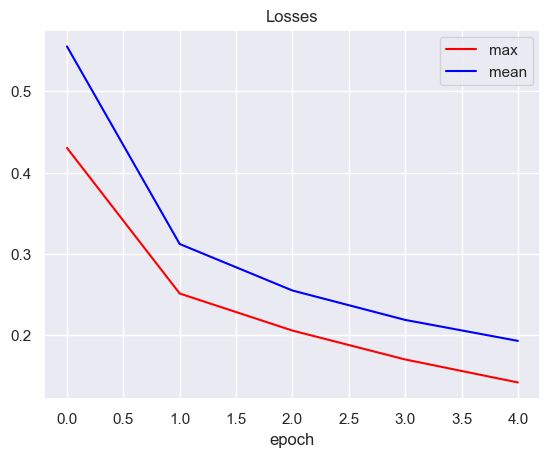

Лучшая accuracy для подхода max: 90.60
Лучшая accuracy для подхода mean: 90.75


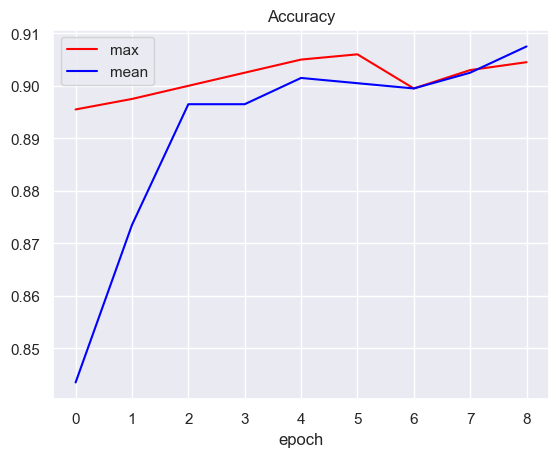

In [14]:
plotting_results(losses_type, acc_type)

### Задание 2.
##### Экспперимент 1. Использование архитектуры GRU.
Результат положительный

In [49]:
class ModelWithGRU_v1(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 2, aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.gru(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [17]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    seed_torch()
    print(f'Starting for {aggregation_type}')
    model = ModelWithGRU_v1(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type, num_classes=4).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training_loop(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Starting for mean


Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

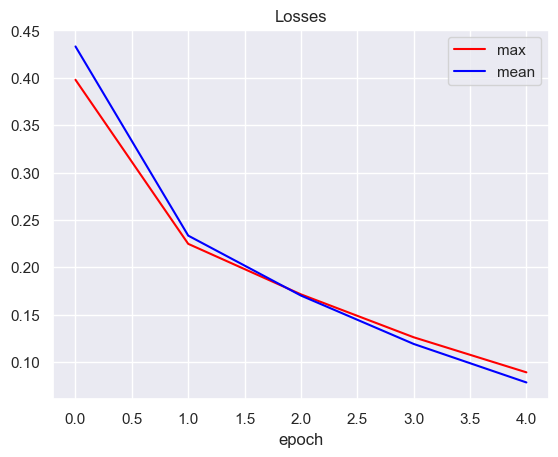

Лучшая accuracy для подхода max: 0.913
Лучшая accuracy для подхода mean: 0.912


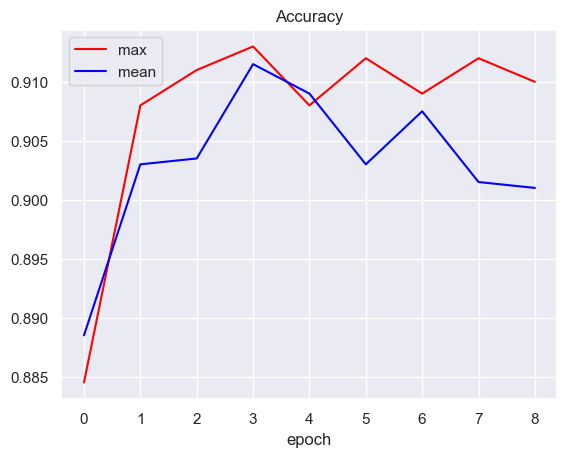

In [21]:
plotting_results(losses_type, acc_type)

##### Эксперимент 2. Изменение числа слоев GRU.
Результат положительный

In [12]:
class ModelWithGRU_v2(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 2, aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.gru(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [57]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    seed_torch()
    print(f'Starting for {aggregation_type}')
    model = ModelWithGRU_v2(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type, num_classes=4).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training_loop(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Starting for mean


Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

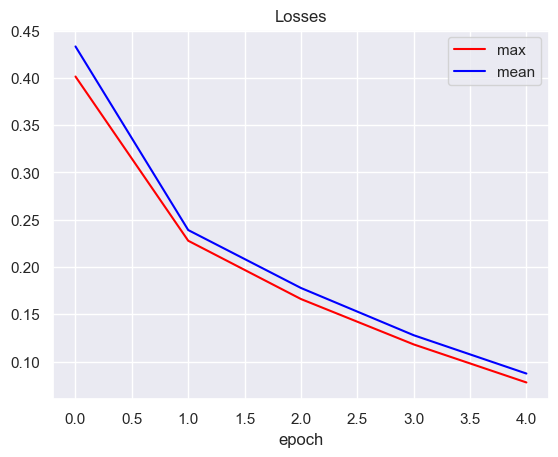

Лучшая accuracy для подхода max: 0.926
Лучшая accuracy для подхода mean: 0.913


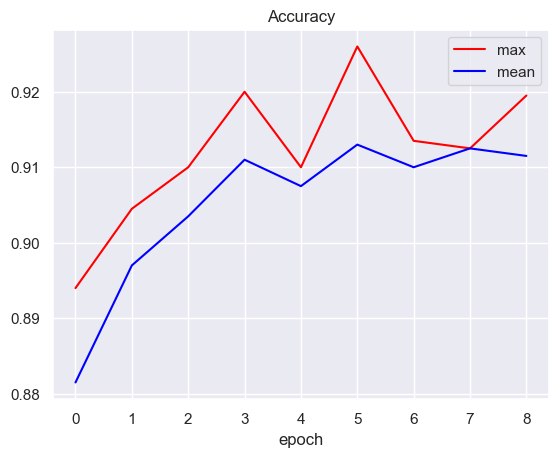

In [58]:
plotting_results(losses_type, acc_type)

##### Эксперимент 3. Изменение числа слоев полносвязной сети.
Результат отрицательный для max, положительный для mean

In [62]:
class ModelWithGRU_v3(nn.Module):
    '''Three layed net with relu after the GRU'''
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 2, aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.first_linear = nn.Linear(hidden_dim, 32)
        self.second_linear = nn.Linear(32, 32)
        self.projection = nn.Linear(32, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.gru(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = (self.dropout(self.second_linear(self.dropout(self.first_linear(self.non_lin(output))))))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [63]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    seed_torch()
    print(f'Starting for {aggregation_type}')
    model = ModelWithGRU_v3(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type, num_classes=4).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training_loop(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Starting for mean


Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

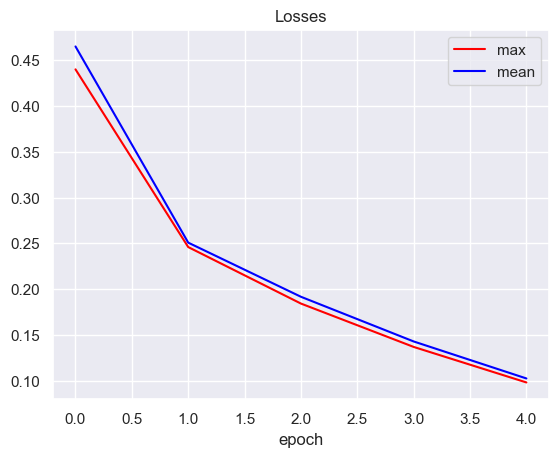

Лучшая accuracy для подхода max: 0.921
Лучшая accuracy для подхода mean: 0.919


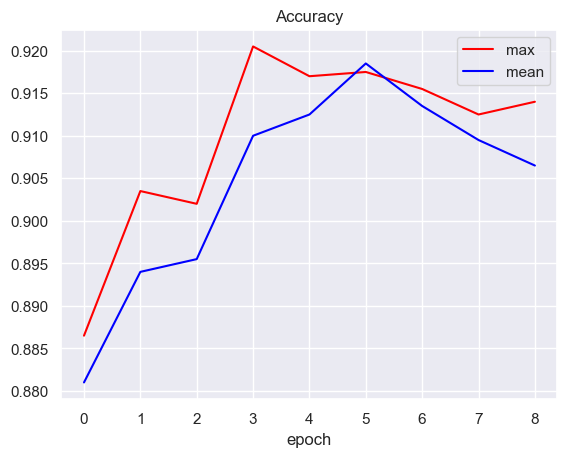

In [65]:
plotting_results(losses_type, acc_type)

##### Эксперимент 4. Изменение числа эпох.
Результат отрицательный

In [13]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    seed_torch()
    print(f'Starting for {aggregation_type}')
    model = ModelWithGRU_v2(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type, num_classes=4).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training_loop(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=10)

Starting for max


Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

Starting for mean


Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

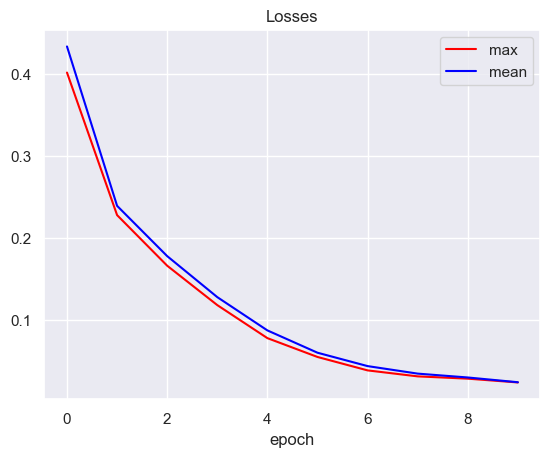

Лучшая accuracy для подхода max: 0.926
Лучшая accuracy для подхода mean: 0.914


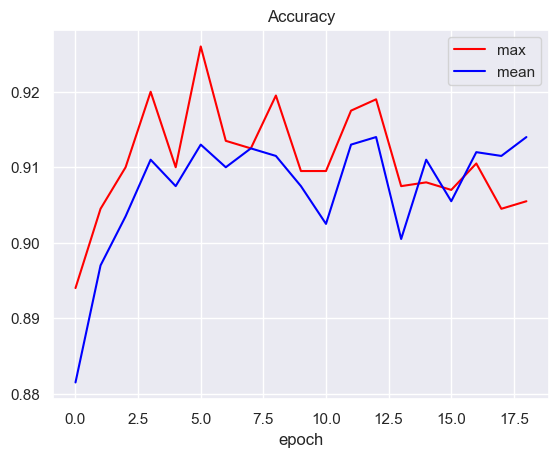

In [14]:
plotting_results(losses_type, acc_type)

### Вывод:
В ходе работы для более объективного сравнения моделей была "зафиксирована" случайность.

В ходе первого экспперимента была использована архитектура GRU, использование которой позволило повысить заначение accuracy на 0,04 и 0,007 для агрегаций mean и max соответсвенно.
Также на качестве положительно сказалось увеличение числа слоев GRU до 2 (acuracy 0,913 и 0,926), увеличение же числа слоев до 3 сказалось негативно, понизив точность до 0,914 и 0,913 (для агрегаций mean и max соответсвенно), и повысив время обучения почти в 1,5 раза.
В ходе третьего эксперимента число слоев полносвязной сети было увеличено до 3. Это позволило повысить заначение accuracy на 0,005 для агрегации mean, однако понизило точность при агрегации max до 0,921.
В ходе последнего экспперимента было увеличено количество эпох обучения, однако прироста к качеству данное изменение не принеесло.
В основном модели показывали лучшее качество по завершинии третьей эпохи обучения, в дальнейшем наблюдаются сильные колебания при отсутвии повышения качества. Лучший результат показала модель с двумя слоями GRU и агрегацией max (0,926). Лучший результат для агрегации mean (0,919) показала модель с двумя слоями GRU и тремя полносвязными слоями.